tabela filtrada:                   process         parent  UID  process_occurrences  fragmented
time_passed                                                                   
6.833333     EMT-1(21817)  nspr-2(16890)    0                   10           0
6.866667     EMT-1(21817)  nspr-2(16890)    0                   10           0
6.900000     EMT-1(21817)  nspr-2(16890)    0                   10           0
6.933333     EMT-1(21817)  nspr-2(16890)    0                   10           0
6.966667     EMT-1(21817)  nspr-2(16890)    0                   10           0
...                   ...            ...  ...                  ...         ...
113.700000   EMT-1(21817)  nspr-2(16890)    0                   19           0
113.733333   EMT-0(21817)  nspr-2(16890)    0                   22           0
113.733333   EMT-1(21817)  nspr-2(16890)    0                   19           0
113.766667   EMT-0(21817)  nspr-2(16890)    0                   22           0
113.766667   EMT-1(21817)  nspr-2(1

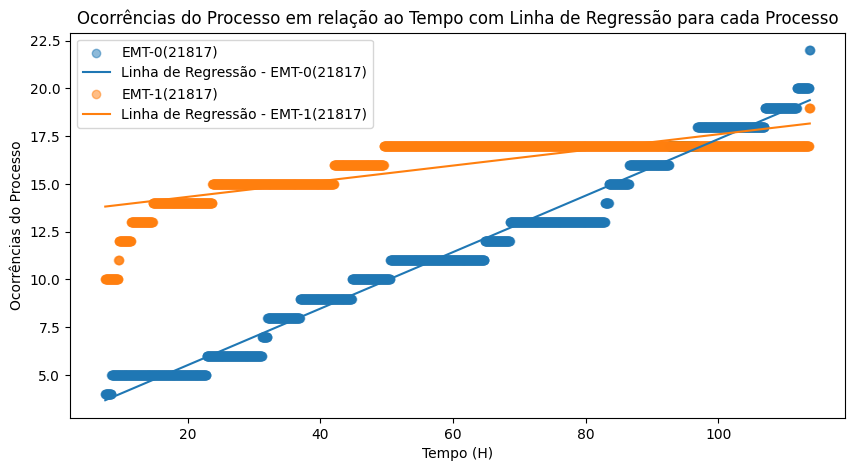

In [5]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt

def ler_csv(caminho_arquivo):
  """
    Read CSV file and return DataFrame.
  """
  try:
    return pd.read_csv(caminho_arquivo, delimiter=";", header=0)

  except FileNotFoundError:
    print("File not found.")
    return None

  except Exception as e:
      print("An error occurred:", str(e))
      return None

def configurar_index_data_frame(data_frame):
  data_frame_index_configurado = data_frame

  # Convert the datetime column to a datetime object
  data_frame_index_configurado['datetime'] = pd.to_datetime(data_frame_index_configurado['datetime'])

  # Set the index to the datetime column
  data_frame_index_configurado = data_frame_index_configurado.set_index('datetime')

  data_frame_index_configurado['time_passed'] = (data_frame_index_configurado.index - data_frame_index_configurado.index[0]).total_seconds() / 3600

  # Resetting the index to use 'time_passed' as index
  data_frame_index_configurado = data_frame_index_configurado.set_index('time_passed')

  return data_frame_index_configurado

def filtrar_data_frame(data_frame):
  data_frame_filtrado = data_frame

  data_frame_filtrado = data_frame_filtrado[data_frame_filtrado['process_occurrences'] >= 4]

  print(f'tabela filtrada: {data_frame_filtrado}')

  return data_frame_filtrado


def pivotar_data_frame(data_frame):
  data_frame_pivotado = data_frame

  data_frame_pivotado = data_frame_pivotado.pivot(columns='process', values='process_occurrences')

  print(f'tabela pivotada: {data_frame_pivotado}')

  data_frame_pivotado = data_frame_pivotado.dropna()

  return data_frame_pivotado


def configurar_regressao(data_frame):
  X = data_frame.index.values.reshape(-1, 1)

  Y = data_frame.iloc[:, 0].values

  print(f'X: {X}')
  print(f'Y: {Y}')

  regression_model = LinearRegression().fit(X, Y)

  r_squared = regression_model.score(X, Y)

  # Adicione uma constante ao x para estimar o intercepto (constante) na regressão
  x_with_const = sm.add_constant(X)

  # Ajuste o modelo de regressão com statsmodels
  regression_model_sm = sm.OLS(Y, x_with_const).fit()

  # Obtenha um resumo completo da regressão
  regression_summary = regression_model_sm.summary()

  # Imprima o resumo
  print(regression_summary)


def fazer_plotagem(data_frame_pivotado):
  # Plotar os dados de ocorrência do processo em relação ao tempo para cada processo
  plt.figure(figsize=(10, 5))

  # Iterar sobre as colunas de data_frame_pivotado
  for column in data_frame_pivotado.columns:
      # Obter os dados de ocorrência do processo e tempo para o processo atual
      Y_process = data_frame_pivotado[column].values
      X = data_frame_pivotado.index.values.reshape(-1, 1)
      Y = Y_process

      # Ajustar o modelo de regressão linear
      regression_model = LinearRegression().fit(X, Y)

      # Plotar os pontos de dados das ocorrências do processo em relação ao tempo para o processo atual
      plt.scatter(X, Y, label=f'{column}', alpha=0.5)

      # Plotar a linha de regressão para o processo atual
      plt.plot(X, regression_model.predict(X), label=f'Linha de Regressão - {column}')

  # Adicionar rótulos e título ao gráfico
  plt.xlabel('Tempo (H)')
  plt.ylabel('Ocorrências do Processo')
  plt.title('Ocorrências do Processo em relação ao Tempo com Linha de Regressão para cada Processo')
  plt.legend()

  # Exibir o gráfico
  plt.show()



caminho_arquivo = '/content/drive/MyDrive/Colab Notebooks/fragmentation.csv'
novo_data_frame = ler_csv(caminho_arquivo)

novo_data_frame = configurar_index_data_frame(novo_data_frame)

novo_data_frame = filtrar_data_frame(novo_data_frame)

data_frame_pivotado = pivotar_data_frame(novo_data_frame)

data_frame_pivotado = fazer_plotagem(data_frame_pivotado)